# Predicting Credit Risk For Loans

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, 
    roc_curve,
    accuracy_score,
    precision_score, 
    recall_score,
    roc_auc_score,
    classification_report
)
import shap
shap.initjs()

In [29]:
df = pd.read_csv("datasets/credit_risk_dataset.csv")

## Light EDA

In [30]:
df.sample(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
7409,24,52000,RENT,3.0,HOMEIMPROVEMENT,A,6600,NaN,0,0.13,N,3
11949,22,62500,RENT,0.0,PERSONAL,C,11100,NaN,0,0.18,Y,3
6251,23,30000,RENT,3.0,DEBTCONSOLIDATION,B,6000,11.71,0,0.20,N,4
8801,24,34000,RENT,0.0,VENTURE,D,8000,16.49,1,0.24,Y,3
28116,35,21600,RENT,1.0,PERSONAL,C,2500,14.35,0,0.12,Y,5


In [31]:
df.shape

(32581, 12)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [33]:
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [34]:
df.nunique()

person_age                      58
person_income                 4295
person_home_ownership            4
person_emp_length               36
loan_intent                      6
loan_grade                       7
loan_amnt                      753
loan_int_rate                  348
loan_status                      2
loan_percent_income             77
cb_person_default_on_file        2
cb_person_cred_hist_length      29
dtype: int64

In [35]:
df.isna().mean()

person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
person_emp_length             0.027470
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_int_rate                 0.095639
loan_status                   0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
dtype: float64

In [36]:
df.duplicated().sum()

165

We will want to drop duplicated rows.

Almost 10% of `loan_int_rate` has missing values. Let's impute everything with the mean later. 

## Preprocessing & Feature Engineering

In [37]:
# Drop duplicate rows
df.drop_duplicates(inplace=True)
df.shape

(32416, 12)

In [38]:
# Fill na values with the respected means
df['person_emp_length'].fillna(df['person_emp_length'].mean(), inplace=True)
df['loan_int_rate'].fillna(df['loan_int_rate'].mean(), inplace=True)
df.shape

(32416, 12)

In [39]:
# Encode categorical variables
loan_grade_mapping = {
    'A': 1,
    'B': 2,
    'C': 3, 
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
}

df['loan_grade'] = df['loan_grade'].replace(loan_grade_mapping)
df = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent', 'cb_person_default_on_file'], drop_first=True)
df.sample(5)

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
28929,30,42000,4.79051,3,4000,15.23,0,0.10,5,False,True,False,False,False,True,False,False,True
27664,28,160000,4.00000,2,34000,9.91,0,0.21,7,False,False,False,False,False,False,False,False,False
20304,31,40000,4.00000,2,4625,12.42,0,0.12,5,False,False,False,False,False,False,False,False,False
2098,21,26400,0.00000,3,2400,14.79,0,0.09,2,False,False,True,True,False,False,False,False,True
29305,50,44000,14.00000,7,20000,20.40,1,0.45,11,False,False,True,False,False,True,False,False,False


Note: Dropping one category (i.e., using drop_first=True) is a common practice, especially in linear models, to avoid the dummy variable trap. A dummy variable trap is a scenario where the model can become overfit or unstable due to multicollinearity.

In [40]:
# Scale continuous features
scaler = StandardScaler()
continuous_cols = [col for col in df.columns if df[col].nunique() > 5]
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])
df.sample(5)

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
92,-0.589708,0.272651,0.051241,0.667787,2.752992,0.802057,1,1.495643,-0.938982,False,False,True,False,False,False,True,False,True
27735,0.826722,1.815029,0.051241,-1.045605,1.645858,-1.306284,0,-0.564083,0.046490,False,False,False,False,True,False,False,False,False
19216,0.197197,-0.614236,1.029639,-1.045605,0.570356,-1.572260,1,2.806378,1.031963,False,False,True,False,False,True,False,False,False
18690,0.984103,-0.357523,-0.682558,0.667787,1.076475,0.004131,1,1.870139,1.031963,False,False,True,False,False,False,False,False,True
22943,0.197197,-0.098229,-1.171757,-1.045605,-0.726572,-1.617670,0,-0.844955,1.031963,False,False,False,False,False,False,True,False,False


## Model Building

In [41]:
# Split the data into features and target
TARGET = 'loan_status'
X = df.drop('loan_status', axis=1)
y = df['loan_status']

In [42]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Train and evaluate the first model
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of True

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Accuracy: {accuracy*100: .1f}% | Precision:{precision*100: .1f}% | Recall:{recall*100: .1f}% | ROC_AUC:{roc_auc*100: .1f}%')

Accuracy:  85.0% | Precision: 73.6% | Recall: 48.8% | ROC_AUC: 71.9%


In [44]:
# Train and evaluate the second model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of True

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Accuracy: {accuracy*100: .1f}% | Precision:{precision*100: .1f}% | Recall:{recall*100: .1f}% | ROC_AUC:{roc_auc*100: .1f}%')

Accuracy:  93.4% | Precision: 97.4% | Recall: 71.7% | ROC_AUC: 85.6%


It's clear that the Random Forest Classifier outperforms logistic regression, so we'll proceed with Random Forest for our analysis.

## Model Evaluation

In [45]:
# Generate classification report summary
class_report = classification_report(y_test, y_pred, target_names=['No Default', 'Default'])
print(class_report)

              precision    recall  f1-score   support

  No Default       0.93      0.99      0.96      5073
     Default       0.97      0.72      0.83      1411

    accuracy                           0.93      6484
   macro avg       0.95      0.86      0.89      6484
weighted avg       0.94      0.93      0.93      6484



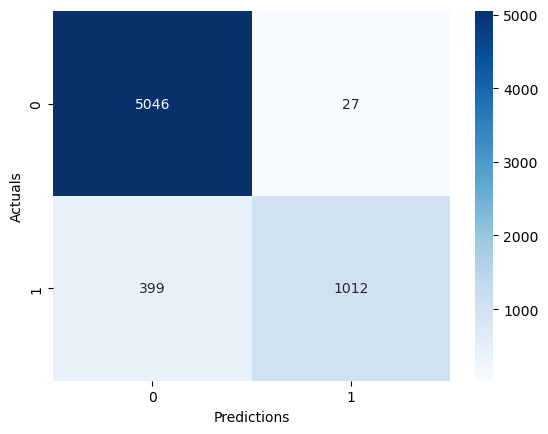

In [46]:
# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g') # 'g' ensures normal integer format
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.show()

The confusion matrix shows that the model is highly effective at correctly identifying the negative class (5032 true negatives) but faces challenges with the positive class, resulting in 390 false negatives. In this scenario, a false negative occurs when the model predicts that the customer will not default, but they actually do. This could be a significant issue, as it means the model is missing instances where customers are likely to default.

In [47]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test , y_pred)

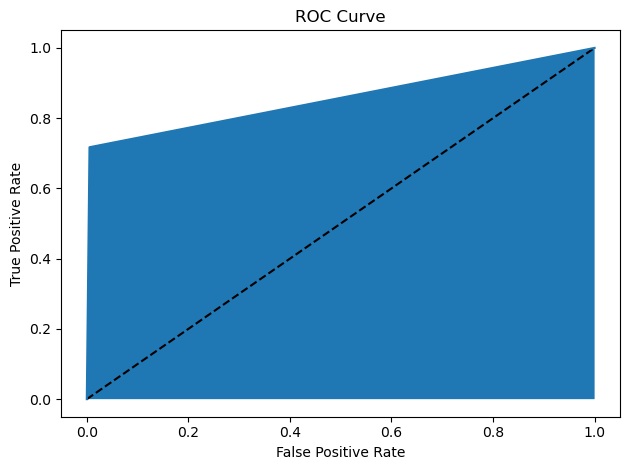

In [48]:
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

plt.fill_between(fpr, tpr)
plt.tight_layout()
plt.show()

## Model Interpretablility

### Feature Importance

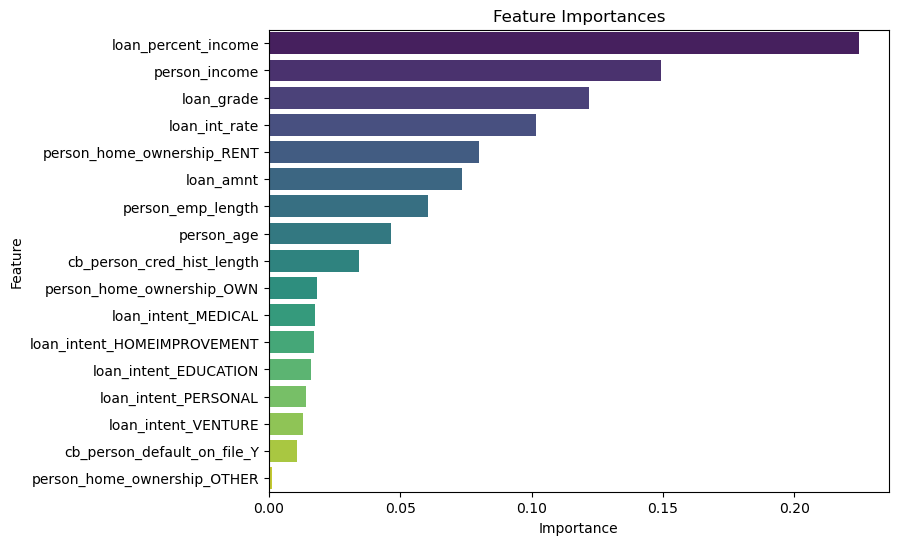

In [49]:
# Plot feature importances
importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

The feature importance plot indicates that `loan_percent_income` and `person_income` are the most influential factors in predicting the outcome, with the highest importance scores. These features significantly impact the model’s decisions, suggesting that the proportion of income dedicated to loan repayment and the overall income of the person are key predictors of loan default risk.

Let's also evaluate the feature importances using SHAP. SHAP values are generally better than traditional feature importance in a random forest classifier because they provide consistent and individualized explanations for each prediction, showing both the direction and magnitude of feature impact. Traditional feature importance, on the other hand, only offers a global view and can be biased, particularly when features are correlated. SHAP values ensure more interpretability and fairness in model explanations. We use *TreeExplainer* here because it is specifically optimized for tree-based models, offering better performance and accuracy in computing SHAP values for Random Forest classifiers.

### Shap Values

In [50]:
# Create explainer object
X_test_sample = X_test[:500]
explainer = shap.TreeExplainer(model) # Use TreeExplainer for tree-based models
shap_values = explainer.shap_values(X_test_sample)

Here’s how to interpret the SHAP values:

Each row in the arrays corresponds to an individual observation (a row of X_test).
Each column represents a feature in your dataset (e.g., `person_age`, `loan_amnt`, etc.).
The SHAP values show the contribution of each feature to the prediction, where:
- Positive values indicate the feature pushes the prediction toward a certain class (e.g., towards class 1, default).
- Negative values indicate the feature pushes the prediction away from that class (e.g., towards class 0, non-default).

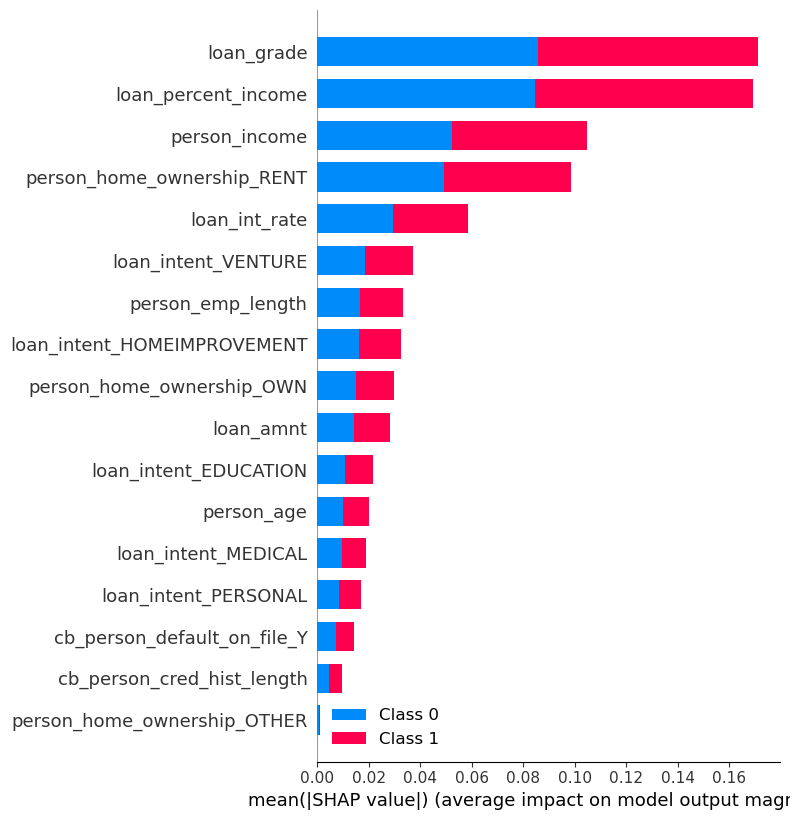

In [51]:
# Plot global summary plot
shap.summary_plot(shap_values, X_test_sample)

`loan_grade` is the most impactful feature, followed by `loan_percent_income`, and `person_income`. `loan_grade` has nearly equal contributions to both Class 0 and Class 1, but it leans slightly more toward Class 1 (red) for predicting defaults. `loan_percent_income` has similar behavior, affecting both classes but slightly leaning toward predicting default (Class 1).

- Red bars show how features push the prediction towards Class 1 (default in this case).
- Blue bars show how features push the prediction towards Class 0 (non-default).

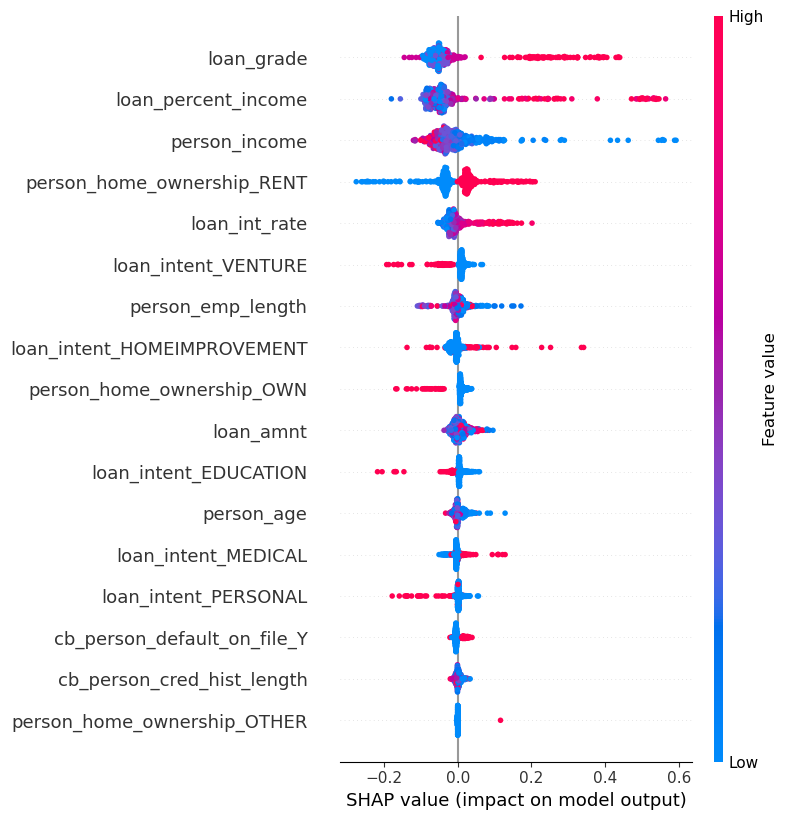

In [52]:
# Plot SHAP summary plot for "default" class (Class 1)
shap.summary_plot(shap_values[1], X_test_sample)

This SHAP summary plot shows the impact of each feature on the model's prediction for Class 1 ("default"). The X-axis represents the SHAP values, where values further from zero indicate a stronger influence of the feature on pushing the prediction toward default. The color gradient (blue to red) represents the feature values, with blue indicating lower values and red indicating higher values. For example, higher values of `loan_percent_income` (in red) strongly push the prediction towards default, while lower values (in blue) push it away. Similarly, higher `loan_grade` and `person_income` also push predictions toward default, suggesting these features are significant factors in determining default risk.

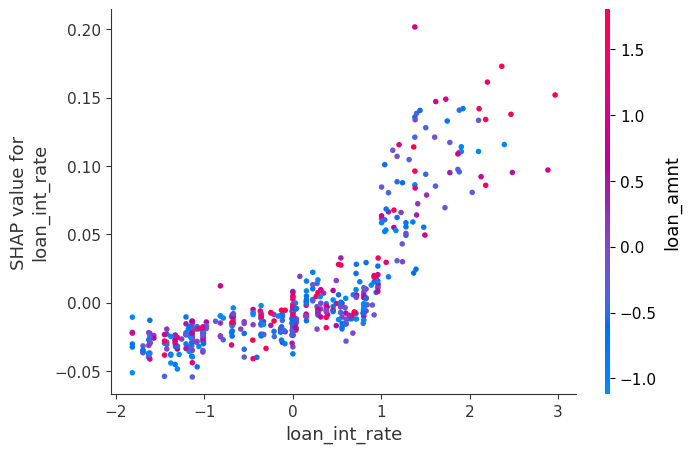

In [53]:
# Create SHAP dependence plot for "loan_int_rate" with interaction effects of "loan_amnt" for default predictions (Class 1)
shap.dependence_plot("loan_int_rate", shap_values[1], X_test_sample, interaction_index="loan_amnt")

This SHAP dependence plot shows how `loan_int_rate` impacts the model's predictions for default (Class 1), with interaction effects from `loan_amnt`. As the interest rate increases, the SHAP value for `loan_int_rate` also increases, indicating that higher interest rates push the model’s predictions toward default. The color gradient represents the loan amount, where red indicates higher loan amounts. The positive correlation between interest rate and SHAP values becomes more pronounced for higher loan amounts, suggesting that the combination of high interest rates and large loan amounts significantly increases the likelihood of default according to the model.

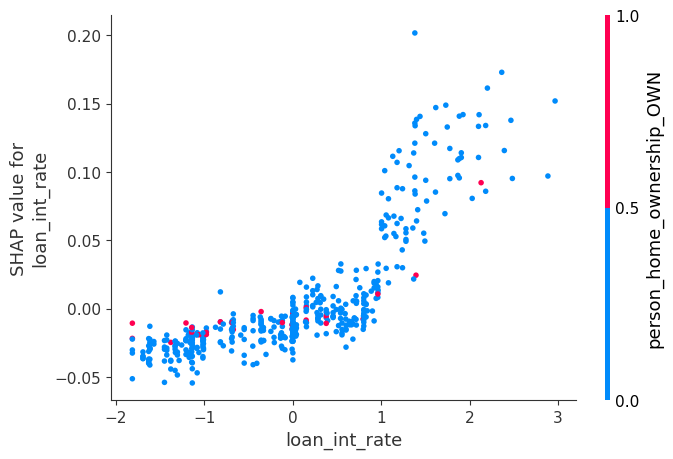

In [54]:
# Create SHAP dependence plot for "loan_int_rate" with interaction effects of "loan_amnt" for default predictions (Class 1)
shap.dependence_plot("loan_int_rate", shap_values[1], X_test_sample)

This SHAP dependence plot provides valuable insights into how `loan_int_rate` (interest rate) impacts the model's predictions for default, with interaction effects from `person_home_ownership_OWN`. As interest rates increase, the SHAP values also rise, indicating that higher interest rates increase the likelihood of default. Additionally, borrowers with higher interest rates are more likely to be non-homeowners, as shown by the predominance of blue points in the higher interest rate range. 

By not specifying an interaction_index="", SHAP automatically selected the most relevant feature interaction—in this case, person_home_ownership_OWN. Allowing SHAP to choose the interaction can be beneficial because it identifies the most impactful interactions in the data, providing a more comprehensive view of how features work together to influence the model's predictions.